### Vi prøver igen ...

- Alle data i en fil, vi korter i koden
- vi prøver med texts_to_matrix
- Jeg kan selv vælge hvad der er stort (kan prøve andet end 10), måske kan den lettere finde f.eks. 5?

### Konklusion
- Det er lykkedes at få det til at virke med een datafil, som indeholder både train og test
- Det er lykkedes at lave en opdeling på et vilkåligt tal i kode for stor og lille
- Data - som de er nu - har ikke ret megen struktur, det var også det jeg egentligt gættede på fra start. De rigtigt store kan modellen godt genkende, men rigtigt mange smutter bare igennem

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
StorEr = 15
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values
labels = np.asarray([1*(NumLines[i]>=StorEr) for i in range(len(NumLines))])

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
labels = labels[indices]

# opdeling i training data og test data
i = 90000  # antal linjer afsat til træning, resten er test
texts_train  = texts[:i]
texts_test   = texts[i:] 
labels_train = labels[:i]
labels_test  = labels[i:]

In [3]:
# laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
labels_train = np.asarray(labels_train).astype('float32')
labels_test = np.asarray(labels_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(90000, 10000)
(10867, 10000)
(90000,)
(10867,)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 10
history = model.fit(data_train, labels_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.1)

Train on 81000 samples, validate on 9000 samples
Epoch 1/10
81000/81000 [==============================] - 18s 224us/step - loss: 0.2817 - acc: 0.9790 - val_loss: 0.1040 - val_acc: 0.9817
Epoch 2/10
81000/81000 [==============================] - 13s 165us/step - loss: 0.1097 - acc: 0.9817 - val_loss: 0.0787 - val_acc: 0.9817
Epoch 3/10
81000/81000 [==============================] - 12s 152us/step - loss: 0.0865 - acc: 0.9818 - val_loss: 0.0753 - val_acc: 0.9819
Epoch 4/10
81000/81000 [==============================] - 15s 189us/step - loss: 0.0799 - acc: 0.9821 - val_loss: 0.0763 - val_acc: 0.9818
Epoch 5/10
81000/81000 [==============================] - 14s 175us/step - loss: 0.0774 - acc: 0.9823 - val_loss: 0.0784 - val_acc: 0.9821
Epoch 6/10
81000/81000 [==============================] - 16s 200us/step - loss: 0.0751 - acc: 0.9825 - val_loss: 0.0784 - val_acc: 0.9822
Epoch 7/10
81000/81000 [==============================] - 14s 170us/step - loss: 0.0735 - acc: 0.9827 - val_loss: 0.0

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

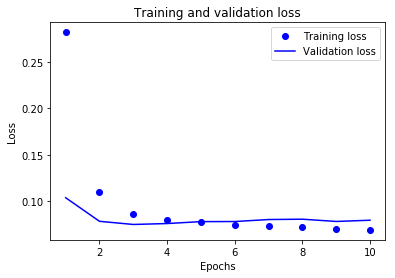

In [9]:
# plotter historikken for 'loss' og 'accuracy'
accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # "bo" is for "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b is for "solid blue line"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

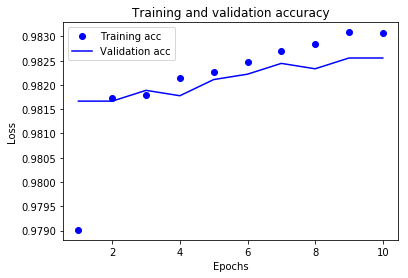

In [10]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [11]:
# vi prøver modellen på test-data

predictions = model.predict(data_test)

for i in range(1,10):
    print(('%1.4f' % predictions[i]))

0.0008
0.0000
0.0095
0.0584
0.0000
0.0170
0.0001
0.0002
0.0106


In [12]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_test))
NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.4 and labels_test[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     165.0
antal estimeret af modellen:  5
Modellens præcision:          3.0 %


In [13]:
# Gennemsnittet for rigtig og forkert

print(' Gennemsnit for test stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels_test[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels_test[i]]))

 Gennemsnit for test stor og lille
0.12514868
0.013843522


In [14]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

print('Jeg printer nogle liner som er sande i test data:')
for i in range(1,300):
    if labels_test[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Jeg printer nogle liner som er sande i test data:
  58  0.0181  Fejl på overkørelse på Svg-banen (HØS). Giver forsinkelser
 104  0.0405  Nedformeringer Øresund / Kystbanen


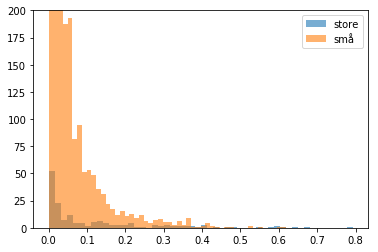

In [15]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_test[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_test[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 200])

plt.show()

UHA UHA, alt for mange af de sande har en værdi tæt på 0 ...

### Modellen er ikke specielt præcis. jeg checker lige efter på træninsdata, dem kan man håbe den har lært bedre at kende???

In [16]:
# vi prøver modellen på test-data

predictions = model.predict(data_train)

# print de første predictions
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

0.0124
0.0235
0.0001
0.1421
0.0347
0.0045
0.0197
0.0212
0.0001


In [17]:
# finder ud af hvor stor en del store, som er fundet

print('Antal store i datasættet:    ', sum(labels_train))
NumEstimated = 0
for i in range(1,len(labels_train)):
    if predictions[i]>0.4 and labels_train[i]:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)
print('Modellens præcision:         ', round(NumEstimated/sum(labels_train)*100), '%')

Antal store i datasættet:     1644.0
antal estimeret af modellen:  342
Modellens præcision:          21.0 %


In [18]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er RIGTIGE (store)

print('Nogle linjer som er SANDE i train data:')
for i in range(1,300):
    if labels_train[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Nogle linjer som er SANDE i train data:
   4  0.1421  Genoprettelse af Svendborgbanen
  18  0.2026  Nedformeringer til og fra Sverige
  25  0.4591  personpåkørsel i HK spor 2
  65  0.1388  BDK ØVRIGE
  99  0.5490  En formentlig selvmorder på Vallensbæk Station som sidder på en bro. Trafikken holder i øjeblikket s
 240  0.0842  Trafik kaos div.
 241  0.1199  Disponering DSB : Falsk besættelse i Gl gør at vi aflyser 4475 og 4477
 285  0.0099  Infrastruktur Ingen Strøm i Malmø


In [19]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er FORKERTE (små)

print('Nogle linjer som er FALSKE i train data:')
for i in range(1,200):
    if labels[i]==0:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

Nogle linjer som er FALSKE i train data:
   1  0.0124  -29 fra Fa
   2  0.0235  Materielmangel ER i Cph
   3  0.0001  L 46. FOKUSTOG.
   5  0.0347  Politi ; Holder i Htå og afventer Politi, voldelig passager, indstigningsdørene er lukket.
   6  0.0045  Materielmangel, MG i Esbjerg
   7  0.0197  Disponering af forsinkelse
   8  0.0212  Disponering DSB:
   9  0.0001  MF 5095 til 100 MM eftersyn
  10  0.0000  Materiel: ATC problemer, 1F3 køres på Hgl til Rep. Kh -31
  11  0.0001  Selv om mat blev klarmeldt kl 00:50, lykkedes det ikke at sætte dem i samme spor, så toget blir ikke
  12  0.0000  Værksted Ar ønsker MQ ud til rep af motor fejl, der byttes.
  13  0.2349  Disponering DSB : opstart af 14xx system  da 13xx er aflyst resten af dagen  1395 /1397/1399 er 
  14  0.0000  Disponering DSB : placering af ET 4301 fra Hg til HGL
  15  0.0027  Materielfejl før afgang
  16  0.0004  Disponering DSB. Mq4115 er færdig på UF i AR. Skal til FA og med i 9198.
  17  0.0226  Er der ingen tysker sæt i

In [20]:
# finder gennemsnittet for dem som er rigtige og forkerte

print(' Gennemsnit for ttrain stor og lille')
print(np.average([x for i, x in enumerate(predictions) if labels[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels[i]]))

 Gennemsnit for ttrain stor og lille
0.20540546
0.012678156


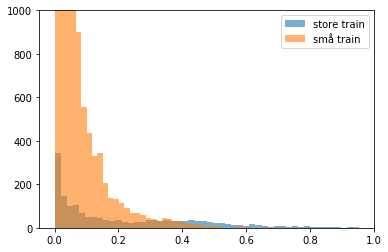

In [21]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels_train[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels_train[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store train')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små train')
plt.legend(loc='upper right')
plt.ylim([0, 1000])

plt.show()